In [3]:
# from IPython.core.display import display,HTML
# display(HTML('<style> div.prompt {display:default} </style>'))

In [1]:
import os, importlib, sys, time, h5py

In [2]:
import numpy as np
from scipy import linalg, stats, ndimage, io
from scipy.sparse import diags

In [3]:
import matplotlib.pyplot as plt
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica'], 'size':13})
## for Palatino and other serif fonts use:
# rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)

In [4]:
import ladyns as ldn
import ladyns.inference as inf
import ladyns.optimize.core as core

In [5]:
importlib.reload(ldn)
importlib.reload(inf)
importlib.reload(core)

<module 'miccs.miccs' from '/home/hbong/miniconda3/lib/python3.7/site-packages/miccs/miccs.py'>

# 0. simulation from model + LFP

In [6]:
save_dir = "../temp"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

## load data

In [7]:
data_dir = "../data/"
file_name = ['lfp_bred_1.mat', 'lfp_bred_2.mat', 'lfp_bred_3.mat']
rec_time = [0, 0.5]

In [8]:
data = [
    np.concatenate([io.loadmat('%s/%s'%(data_dir, fname))['v4_bred']
                    for fname in file_name], 0)[:,:,:100:2].T,
    np.concatenate([io.loadmat('%s/%s'%(data_dir, fname))['pfc_bred']
                    for fname in file_name], 0)[:,:,:100:2].T]

In [9]:
data[0].shape, data[1].shape

((50, 25, 3000), (50, 25, 3000))

In [10]:
dims = [data[0].shape[1], data[1].shape[1]]
num_time = data[0].shape[0]
obs_trial = data[0].shape[2]

## load LaDynS run on data

In [11]:
result_exp = np.load('%s/result_exp.npz'%save_dir)
Sigma_exp = result_exp['Sigma_est']
weight_exp = result_exp['weight_est']

## cross precision

In [12]:
num_blobs = 3

In [13]:
times = np.array([[1, 1, 12], [21, 18, 6], [32, 37, 9]])

In [14]:
H0 = np.zeros((times.shape[0], num_time, num_time))
for i, (time_0, time_1, duration) in enumerate(times):
    H0[i, time_0:time_0+duration, time_1:time_1+duration] \
    = np.abs(np.arange(duration)-np.arange(duration)[:,None]) < 2

(0.0, 1.0, 0.0, 1.0)

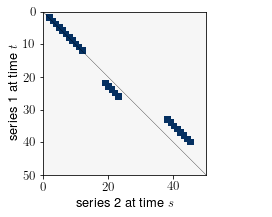

In [15]:
import matplotlib.gridspec as gridspec
plt.figure(figsize=(4,3))
gridspec.GridSpec(1,4); plt.subplot2grid((1,4), (0,0), colspan=3, rowspan=1)
ldn.imshow(np.sum(H0, 0), time=[0,50], identity=True, vmax=1)
plt.ylabel(r'series 1 at time $t$'); plt.xlabel(r'series 2 at time $s$')
ax = plt.subplot2grid((1,4), (0,3))
ax.axis('off')

## latent direction

In [20]:
mu = [np.mean(dat, -1) for dat in data]
covs = [
    np.matmul(dat - m[...,None], dat - m[...,None], axes=[(1,2),(2,1),(1,2)])/obs_trial
    for dat, m in zip(data, mu)]

In [21]:
weights_exp = [np.array(weight_exp[:num_time]),
               np.array(weight_exp[num_time:])]
betas_exp = [(cov @ w[...,None])[...,0] for cov ,w in zip(covs, weights_exp)]

## latent precision

In [22]:
sighat = Sigma_exp.copy()
sighat_1 = sighat[:num_time,:num_time]
sighat_2 = sighat[num_time:,num_time:]

In [23]:
Y_mm_1 = np.concatenate([[0], np.cumsum(np.sqrt(-2*np.log(
    sighat_1[np.arange(1,num_time), np.arange(0,num_time-1)])))])
Y_mm_2 = np.concatenate([[0], np.cumsum(np.sqrt(-2*np.log(
    sighat_2[np.arange(1,num_time), np.arange(0,num_time-1)])))])

In [24]:
sigmm_1 = np.exp(-(np.square(Y_mm_1[:,None] - Y_mm_1[None,:])/2))
sigmm_2 = np.exp(-(np.square(Y_mm_2[:,None] - Y_mm_2[None,:])/2))

In [25]:
precs_auto = [linalg.inv(S + 0.5 * np.eye(num_time))
              for S in [sigmm_1, sigmm_2]] 

In [26]:
snr = 0.006
prec_latent = np.array(np.block([
    [precs_auto[0], -snr*np.sum(H0,0)],
    [-snr*np.sum(H0,0).T, precs_auto[1]]
]))
cov_latent = linalg.inv(prec_latent)

In [27]:
cov_latent = cov_latent + np.real(np.min(linalg.eig(Sigma_exp)[0]) - np.min(linalg.eig(cov_latent)[0]))*np.eye(2*num_time)
sd_latent = np.sqrt(np.diag(cov_latent))
corr_latent = cov_latent / sd_latent / sd_latent[:,None]
chol_latent = linalg.cholesky(corr_latent)

## simulate

In [29]:
obs_trial = data[0].shape[2]
num_trial = 3000

In [30]:
dummy = [dat[:,:,np.random.choice(obs_trial, num_trial, replace=False)]
         for dat, dim in zip(data, dims)]
ldummy = [np.squeeze(np.matmul(dir_i[:,None,:], dumm - np.mean(dumm, -1, keepdims=True)))
          for dir_i, dumm in zip(weights_exp, dummy)]

# cov_ldummy = np.cov(ldummy[0], ldummy[1])
# sd_ldummy = np.sqrt(np.diag(cov_ldummy))

latent_variables = (chol_latent.T @ np.random.normal(0, 1, (2*num_time, num_trial)))

# ATTN: identifiability constraint not satisfied here (compare with 3_1_simulation.ipynb)
pops = [dummy[0] + betas_exp[0][:,:,None] * (latent_variables[:num_time,None,:]),
        dummy[1] + betas_exp[1][:,:,None] * (latent_variables[num_time:,None,:])]

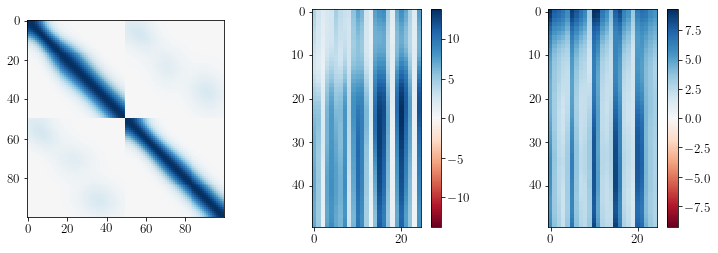

In [34]:
plt.figure(figsize=(12, 4))
plt.subplot(1,3,1); ldn.imshow(chol_latent.T @ chol_latent)
plt.subplot(1,3,2); ldn.imshow(np.array(betas_exp[0])); plt.colorbar()
plt.subplot(1,3,3); ldn.imshow(np.array(betas_exp[1])); plt.colorbar()

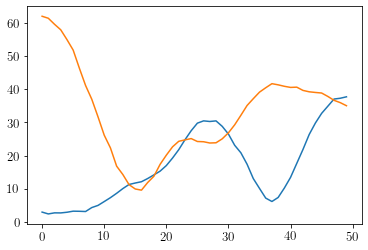

In [35]:
plt.plot(pops[0][:,0,0])
plt.plot(pops[1][:,0,0])

# 1. crossvalidation

In [36]:
offset_cross=10
offset_auto=10
lambdas= np.vstack([
    np.exp(np.linspace(np.log(0.1), np.log(0.001), 11)), #np.full((11,), 0.06), ## lambdas_cross
    np.zeros(11), ## lambdas_auto
    np.full((11,), 0.5), ## lambdas_diag
    np.zeros(11)]) ## lambdas_ridge

In [37]:
time_graph_cross = (np.abs(np.subtract(*np.where(
    np.full([num_time,num_time],True)))
       .reshape([num_time,num_time])) < offset_cross)
time_graph_auto = (np.abs(np.subtract(*np.where(
    np.full([num_time,num_time],True)))
       .reshape([num_time,num_time])) < offset_auto)

In [121]:
rec_time = [0,50]

In [122]:
b_time = np.linspace(rec_time[0], rec_time[1], num_time)
l_time = np.linspace(rec_time[0], rec_time[1], 2*num_time-1)

## RIC

In [39]:
num_cv = 10

In [40]:
Omegas_cv = np.zeros([num_cv, lambdas.shape[-1], 2*num_time, 2*num_time])
weights_cv = []

for iter_cv in np.arange(num_cv):
    start_cv = time.time()
    
    # random sample
    trial_sample = np.random.choice(num_trial, num_trial, False)
    data_bst = [pops[0], pops[1][:,:,trial_sample]]

    for iter_est, (lambda_cross, lambda_auto, lambda_diag, lambda_ridge) \
    in enumerate(zip(*lambdas)): 
        if iter_cv > 0:
            init_arg = {'Omega_init': Omegas_cv[0,iter_est],
                        'weight_init': weights_cv[iter_est]}
        elif iter_est > 0:
            init_arg = {'Omega_init': Omegas_cv[0,iter_est-1],
                        'weight_init': weights_cv[iter_est-1]}
        else:
            init_arg = dict()

        Omega_est, Sigma_est, latent_est, weight_est \
        = ldn.fit(data_bst, lambda_diag, lambda_cross, offset_cross,
                   lambda_auto, offset_auto, 
                   ths_glasso=1e-6, ths_lasso=1e-6, verbose=True,
                   **init_arg)
        
        # save result
        Omegas_cv[iter_cv, iter_est] = Omega_est
        if iter_cv == 0:
            weights_cv.append(weight_est)

    sys.__stdout__.write("%d-th cv finished, lapse: %.3fsec.\n"
                         %(iter_cv+1, time.time()-start_cv))
    sys.__stdout__.flush()

1-th iter, nll: 67.475576, change: 0.076374, lapse: 0.557242
2-th iter, nll: 67.424162, change: 0.007312, lapse: 0.494008
3-th iter, nll: 67.384980, change: 0.004884, lapse: 0.481781
4-th iter, nll: 67.353451, change: 0.003537, lapse: 0.460041
5-th iter, nll: 67.327275, change: 0.002893, lapse: 0.460006
6-th iter, nll: 67.305103, change: 0.002614, lapse: 0.447937
7-th iter, nll: 67.286055, change: 0.002399, lapse: 0.435414
8-th iter, nll: 67.269517, change: 0.002217, lapse: 0.425923
9-th iter, nll: 67.255041, change: 0.002065, lapse: 0.425771
10-th iter, nll: 67.242285, change: 0.001932, lapse: 0.415669
11-th iter, nll: 67.230982, change: 0.001810, lapse: 0.410752
12-th iter, nll: 67.220918, change: 0.001697, lapse: 0.409891
13-th iter, nll: 67.211920, change: 0.001591, lapse: 0.397973
14-th iter, nll: 67.203846, change: 0.001497, lapse: 0.395564
15-th iter, nll: 67.196576, change: 0.001413, lapse: 0.395175
16-th iter, nll: 67.190012, change: 0.001335, lapse: 0.385670
17-th iter, nll: 

2-th iter, nll: 67.126518, change: 0.000464, lapse: 0.334945
1-th iter, nll: 67.124289, change: 0.061250, lapse: 0.361887
2-th iter, nll: 67.123277, change: 0.000428, lapse: 0.320883
1-th iter, nll: 67.121419, change: 0.062794, lapse: 0.380987
2-th iter, nll: 67.120531, change: 0.000397, lapse: 0.321201
1-th iter, nll: 67.119029, change: 0.063671, lapse: 0.380954
2-th iter, nll: 67.118247, change: 0.000370, lapse: 0.312943
1-th iter, nll: 67.158063, change: 0.000905, lapse: 0.363616
1-th iter, nll: 67.154927, change: 0.000859, lapse: 0.364963
1-th iter, nll: 67.149404, change: 0.009135, lapse: 0.353889
2-th iter, nll: 67.146965, change: 0.000752, lapse: 0.355020
1-th iter, nll: 67.144663, change: 0.023329, lapse: 0.354148
2-th iter, nll: 67.142592, change: 0.000686, lapse: 0.359675
1-th iter, nll: 67.140270, change: 0.039113, lapse: 0.355595
2-th iter, nll: 67.138501, change: 0.000632, lapse: 0.342376
1-th iter, nll: 67.136163, change: 0.050336, lapse: 0.356047
2-th iter, nll: 67.13464

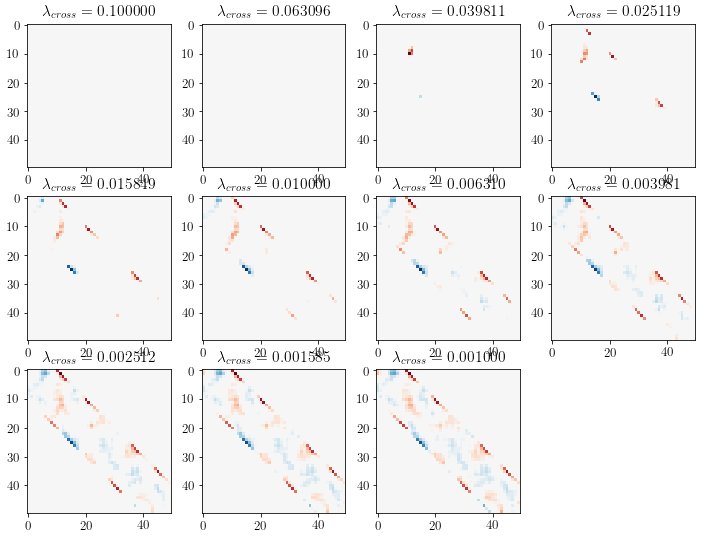

In [41]:
plt.figure(figsize=(12,3*np.ceil(lambdas.shape[-1]/4)))
for iter_lambda, (lambda_cross, lambda_auto, lambda_diag, lambda_ridge) \
in enumerate(zip(*lambdas)):
    plt.subplot(np.ceil(lambdas.shape[-1]/4), 4, iter_lambda+1)
    ldn.imshow(Omegas_cv[0, iter_lambda,:num_time,num_time:], identity=True)
    plt.title(r'$\lambda_{cross} = %f$'%lambda_cross)

In [42]:
fds_cv = np.sum(Omegas_cv[:,:,:num_time,num_time:]!=0,(0,-2,-1))/num_cv
fdrs_cv = np.sum(Omegas_cv[:,:,:num_time,num_time:]!=0,(0,-2,-1))/np.sum(time_graph_cross)/num_cv

Text(0, 0.5, 'mean false discovery')

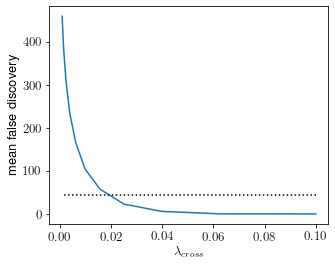

In [43]:
plt.figure(figsize=(5,4))
plt.plot(lambdas[0], fds_cv)
plt.plot(lambdas[0], np.full(lambdas[0].shape, 0.05*np.sum(time_graph_cross)), color='black', linestyle=':')
plt.xlabel(r"$\lambda_{cross}$")
plt.ylabel(r"mean false discovery")

# cv result

In [44]:
id_cv = np.argmax(fdrs_cv[fdrs_cv < 0.05])

In [45]:
lambda_cross, lambda_auto, lambda_diag, lambda_ridge = lambdas.T[id_cv]
lambda_cross, lambda_auto, lambda_diag, lambda_ridge

(0.025118864315095805, 0.0, 0.5, 0.0)

In [46]:
lambda_graph = np.array(np.block(
    [[(1+lambda_auto)*(time_graph_auto-np.eye(num_time)) + (1+lambda_diag)*np.eye(num_time), (1+lambda_cross)*time_graph_cross],
     [(1+lambda_cross)*time_graph_cross, (1+lambda_auto)*(time_graph_auto-np.eye(num_time)) + (1+lambda_diag)*np.eye(num_time)]])) -1

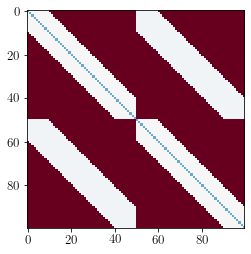

In [47]:
ldn.imshow(lambda_graph)

In [48]:
# initialization by CCA
S_xt = np.cov(*[dat.transpose([1,0,2]).reshape([d,-1])
            for dat, d in zip(data, dims)])
S_1 = S_xt[:dims[0],:dims[0]]
S_12 = S_xt[:dims[0],dims[0]:]
S_2 = S_xt[dims[0]:,dims[0]:]

U_1= linalg.inv(linalg.sqrtm(S_1))
U_2 = linalg.inv(linalg.sqrtm(S_2))

u, s, vh = np.linalg.svd(U_1 @ S_12 @ U_2)
weight_init = [(U_1 @ u[:,0]).copy() for _ in np.arange(num_time)] \
            + [ (U_2 @ vh[0]).copy() for _ in np.arange(num_time)]

In [49]:
Omega_est, Sigma_est, latent_est, weight_est \
= ldn.fit(pops, lambda_diag, lambda_cross, offset_cross,
          lambda_auto, offset_auto, 
          ths_glasso=1e-6, ths_lasso=1e-6, verbose=True)

1-th iter, nll: 67.465311, change: 0.076373, lapse: 0.553924
2-th iter, nll: 67.413662, change: 0.007327, lapse: 0.499112
3-th iter, nll: 67.374276, change: 0.004892, lapse: 0.490577
4-th iter, nll: 67.342582, change: 0.003549, lapse: 0.471709
5-th iter, nll: 67.316279, change: 0.002898, lapse: 0.463782
6-th iter, nll: 67.294013, change: 0.002617, lapse: 0.446999
7-th iter, nll: 67.274901, change: 0.002401, lapse: 0.433986
8-th iter, nll: 67.258324, change: 0.002218, lapse: 0.421714
9-th iter, nll: 67.243830, change: 0.002065, lapse: 0.422608
10-th iter, nll: 67.231073, change: 0.001931, lapse: 0.410863
11-th iter, nll: 67.219785, change: 0.001808, lapse: 0.409978
12-th iter, nll: 67.209747, change: 0.001694, lapse: 0.417175
13-th iter, nll: 67.200785, change: 0.001587, lapse: 0.399963
14-th iter, nll: 67.192753, change: 0.001493, lapse: 0.406616
15-th iter, nll: 67.185532, change: 0.001409, lapse: 0.396761
16-th iter, nll: 67.179020, change: 0.001329, lapse: 0.383057
17-th iter, nll: 

In [51]:
dspr_est = 2*Omega_est - Omega_est @ Sigma_est @ Omega_est

## plots

Text(0.5, 0, 'series 2 at time $s$')

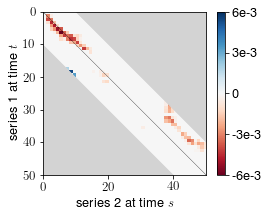

In [124]:
plt.figure(figsize=(4,3))
ldn.imshow(Omega_est[:num_time,num_time:], time=[0,50], identity=True)
plt.fill_between((b_time[offset_cross], rec_time[1]), 
                (rec_time[0], rec_time[0]), 
                (rec_time[0], rec_time[1]-b_time[offset_cross]+rec_time[0]), color='lightgray')
plt.fill_between((rec_time[0], rec_time[1]-b_time[offset_cross]+rec_time[0]), 
                (b_time[offset_cross], rec_time[1]), 
                (rec_time[1], rec_time[1]), color='lightgray')
plt.clim(-0.006,0.006); cbar = plt.colorbar(ticks=[-0.006, -0.003, 0.0, 0.003, 0.006])
cbar.ax.set_yticklabels(['-6e-3','-3e-3','0','3e-3','6e-3'])
ax.set_xlim(rec_time[0], rec_time[1]); ax.set_ylim(rec_time[1], rec_time[0])
plt.ylabel(r'series 1 at time $t$'); plt.xlabel(r'series 2 at time $s$')

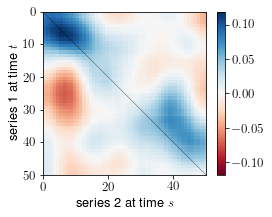

In [55]:
plt.figure(figsize=(4,3))
ldn.imshow(Sigma_est[:num_time,num_time:], time=[0,50], identity=True)
plt.ylabel(r'series 1 at time $t$'); plt.xlabel(r'series 2 at time $s$')
plt.colorbar()

# 2. Permutation test

In [56]:
num_perm = 200

In [57]:
init_arg = {'Omega_init': Omegas_cv[0,id_cv],
            'weight_init': weights_cv[id_cv]}

In [58]:
Omegas_perm = np.zeros([num_perm, 2*num_time, 2*num_time])
Sigmas_perm = np.zeros([num_perm, 2*num_time, 2*num_time])

for iter_perm in range(num_perm):    
    while True:
        with np.errstate(all='raise'):
            try:
                start_perm = time.time()
                
                # random sample
                trial_sample = np.random.choice(num_trial, num_trial, False)
                data_bst = [data[0], data[1][:,:,trial_sample]]

                # permutation
                Omega_perm, Sigma_perm, latent_perm, weight_perm \
                = ldn.fit(data_bst, lambda_diag, lambda_cross, offset_cross,
                          lambda_auto, offset_auto, 
                          ths_glasso=1e-6, ths_lasso=1e-6, verbose=True,
                          **init_arg)
        
                
            except FloatingPointError:
                sys.__stdout__.write("%d-th permutation encountered FloatingPointError, lapse:%.3fsec.\n"
                                     %(iter_perm+1, time.time()-start_perm))
                sys.__stdout__.write("Retrying...\n")
                sys.__stdout__.flush()
                continue
                
            init_arg = {'Omega_init':Omega_perm, 'weight_init':weight_perm}
                        
            # save result
            Omegas_perm[iter_perm] = Omega_perm
            Sigmas_perm[iter_perm] = Sigma_perm
            
            sys.__stdout__.write("%d-th permutation finished, lapse: %.3fsec.\n"
                          %(iter_perm+1, time.time()-start_perm))
            sys.__stdout__.flush()
            break

1-th iter, nll: 67.135773, change: 0.058112, lapse: 0.593369
2-th iter, nll: 67.120668, change: 0.002493, lapse: 0.440557
3-th iter, nll: 67.109942, change: 0.001845, lapse: 0.415908
4-th iter, nll: 67.101452, change: 0.001532, lapse: 0.402876
5-th iter, nll: 67.094357, change: 0.001354, lapse: 0.402587
6-th iter, nll: 67.088246, change: 0.001261, lapse: 0.394134
7-th iter, nll: 67.082884, change: 0.001198, lapse: 0.399112
8-th iter, nll: 67.078123, change: 0.001140, lapse: 0.379359
9-th iter, nll: 67.073861, change: 0.001086, lapse: 0.381099
10-th iter, nll: 67.070020, change: 0.001033, lapse: 0.378350
11-th iter, nll: 67.066543, change: 0.000983, lapse: 0.367085
1-th iter, nll: 67.062757, change: 0.023981, lapse: 0.367989
2-th iter, nll: 67.059895, change: 0.000890, lapse: 0.366906
1-th iter, nll: 67.057702, change: 0.023502, lapse: 0.366170
2-th iter, nll: 67.055280, change: 0.000831, lapse: 0.358629
1-th iter, nll: 67.053227, change: 0.013625, lapse: 0.356686
2-th iter, nll: 67.051

1-th iter, nll: 67.020072, change: 0.026879, lapse: 0.299041
2-th iter, nll: 67.020065, change: 0.000044, lapse: 0.234054
1-th iter, nll: 67.019873, change: 0.022542, lapse: 0.288136
2-th iter, nll: 67.019866, change: 0.000083, lapse: 0.233600
1-th iter, nll: 67.020143, change: 0.022190, lapse: 0.295584
2-th iter, nll: 67.020137, change: 0.000040, lapse: 0.221663
1-th iter, nll: 67.019356, change: 0.018754, lapse: 0.318936
2-th iter, nll: 67.019349, change: 0.000089, lapse: 0.223825
1-th iter, nll: 67.018935, change: 0.042226, lapse: 0.277500
2-th iter, nll: 67.018927, change: 0.000086, lapse: 0.222918
1-th iter, nll: 67.019641, change: 0.033894, lapse: 0.299649
2-th iter, nll: 67.019635, change: 0.000057, lapse: 0.245924
1-th iter, nll: 67.019941, change: 0.017202, lapse: 0.265481
2-th iter, nll: 67.019937, change: 0.000027, lapse: 0.253964
1-th iter, nll: 67.019946, change: 0.016095, lapse: 0.243249
2-th iter, nll: 67.019942, change: 0.000058, lapse: 0.222301
1-th iter, nll: 67.01992

1-th iter, nll: 67.019746, change: 0.018546, lapse: 0.264114
2-th iter, nll: 67.019745, change: 0.000058, lapse: 0.231638
1-th iter, nll: 67.019871, change: 0.018293, lapse: 0.253901
2-th iter, nll: 67.019870, change: 0.000046, lapse: 0.222712
1-th iter, nll: 67.019823, change: 0.022927, lapse: 0.266678
2-th iter, nll: 67.019822, change: 0.000096, lapse: 0.212138
1-th iter, nll: 67.019941, change: 0.011318, lapse: 0.233557
2-th iter, nll: 67.019940, change: 0.000058, lapse: 0.214110
1-th iter, nll: 67.019321, change: 0.027951, lapse: 0.266052
2-th iter, nll: 67.019319, change: 0.000072, lapse: 0.234185
1-th iter, nll: 67.019727, change: 0.025149, lapse: 0.299217
2-th iter, nll: 67.019725, change: 0.000043, lapse: 0.256139
1-th iter, nll: 67.019670, change: 0.017610, lapse: 0.267376
2-th iter, nll: 67.019669, change: 0.000064, lapse: 0.223010
1-th iter, nll: 67.019245, change: 0.029978, lapse: 0.287711
2-th iter, nll: 67.019243, change: 0.000065, lapse: 0.245573
1-th iter, nll: 67.01954

1-th iter, nll: 67.019821, change: 0.025906, lapse: 0.296288
2-th iter, nll: 67.019819, change: 0.000090, lapse: 0.203193


# 3. Inference by STAR

In [104]:
alpha = 0.1
roi = (np.abs(np.subtract(*np.where(
    np.full([num_time,num_time],True)))
       .reshape([num_time,num_time])) < offset_cross-1)

In [59]:
dspr_est = 2*Omega_est - Omega_est @ Sigma_est @ Omega_est
dsprs_perm = 2*Omegas_perm - Omegas_perm @ Sigmas_perm @ Omegas_perm

In [108]:
dist_dspr_est = (dspr_est[:num_time,num_time:] / np.std(dsprs_perm[:,:num_time,num_time:],0))
dist_dspr_perm = (dsprs_perm[:,:num_time,num_time:]
                 / np.std(dsprs_perm[:,:num_time,num_time:],0))

In [110]:
pval_est = np.full(dist_dspr_est.shape, 0.5)
pval_est[roi] = np.clip(2*stats.norm.cdf(-np.abs(dist_dspr_est[roi])), 1e-10, 1-1e-10)

In [114]:
R, fdp, score, mask = \
    inf.STAR_seq_step(pval_est, prop_carve = 0.05, alphas = [alpha],
                      sigma=1, mux_init=-np.log(alpha), roi=roi)
rej_STAR = mask[0]

## plots

Text(0.5, 0, 'series 2 at time $s$')

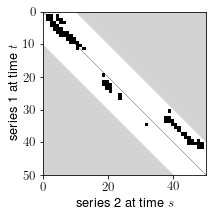

In [128]:
plt.figure(figsize=(4,3))
ldn.imshow(pval_est > 0.01, cmap='gray', vmin=0, vmax=0.01, time=rec_time, identity=True)
plt.fill_between((b_time[offset_cross], rec_time[1]), 
                (rec_time[0], rec_time[0]), 
                (rec_time[0], rec_time[1]-b_time[offset_cross]+rec_time[0]), color='lightgray')
plt.fill_between((rec_time[0], rec_time[1]-b_time[offset_cross]+rec_time[0]), 
                (b_time[offset_cross], rec_time[1]), 
                (rec_time[1], rec_time[1]), color='lightgray')

#cbar = plt.colorbar(ticks=[0, 0.01])
#cbar.ax.set_yticklabels(['0.00','$>$ 0.01'])
plt.ylabel(r'series 1 at time $t$'); plt.xlabel(r'series 2 at time $s$')
# plt.yticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5], ['','','','','','',''])

([<matplotlib.axis.YTick at 0x7fd033fa6050>,
 <a list of 6 Text yticklabel objects>)

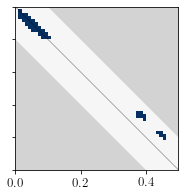

In [117]:
fig, ax = plt.subplots(figsize=(3,3))
ldn.imshow(rej_STAR, time=rec_time, identity=True)

ax.fill_between((b_time[offset_cross], rec_time[1]), 
                (rec_time[0], rec_time[0]), 
                (rec_time[0], rec_time[1]-b_time[offset_cross]+rec_time[0]), color='lightgray')
ax.fill_between((rec_time[0], rec_time[1]-b_time[offset_cross]+rec_time[0]), 
                (b_time[offset_cross], rec_time[1]), 
                (rec_time[1], rec_time[1]), color='lightgray')
plt.clim(-0.001,0.001); # cbar = plt.colorbar(ticks=[-0.010, -0.005, 0.0, 0.005, 0.01])
# cbar.ax.set_yticklabels([r'$<$ -0.010','-0.005','0.000','0.005',r'$>$ 0.010'])
ax.set_xlim(rec_time[0], rec_time[1]), ax.set_ylim(rec_time[1], rec_time[0])
ax.set_xlabel(r" ")
plt.yticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5], ['','','','','','',''])

[Text(1, 0, '-12e-3'),
 Text(1, 0, '-6e-3'),
 Text(1, 0, '0'),
 Text(1, 0, '6e-3'),
 Text(1, 0, '12e-3')]

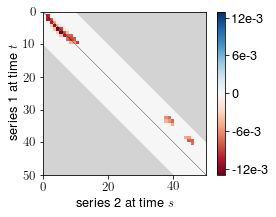

In [127]:
plt.figure(figsize=(4,3))
ldn.imshow(rej_STAR * dspr_est[:num_time,num_time:], time=rec_time, identity=True)
plt.fill_between((b_time[offset_cross], rec_time[1]), 
                (rec_time[0], rec_time[0]), 
                (rec_time[0], rec_time[1]-b_time[offset_cross]+rec_time[0]), color='lightgray')
plt.fill_between((rec_time[0], rec_time[1]-b_time[offset_cross]+rec_time[0]), 
                (b_time[offset_cross], rec_time[1]), 
                (rec_time[1], rec_time[1]), color='lightgray')
plt.xlim(rec_time[0], rec_time[1]); plt.ylim(rec_time[1], rec_time[0])
plt.ylabel(r'series 1 at time $t$'); plt.xlabel(r'series 2 at time $s$')
cbar = plt.colorbar(ticks=[-0.012, -0.006, 0.0, 0.006, 0.012])
cbar.ax.set_yticklabels([r'-12e-3','-6e-3','0','6e-3',r'12e-3'])

# 4. Inference by excursion test

In [85]:
ths_nv = 0.05

In [86]:
rej_nv_est = pval_est < ths_nv
rejs_nv_perm = pvals_perm < ths_nv

In [87]:
rbs_nv_perm = np.zeros((num_perm, num_time, num_time))
nbs_nv_perm = np.zeros((num_perm,))

for iter_perm in range(num_perm):
    mask_cp = rejs_nv_perm[iter_perm].copy(); iter_blob = 0
    while np.any(mask_cp):
        iter_blob += 1
        queue = [tuple(np.transpose(np.where(mask_cp))[0])]
        mask_cp[queue[0]] = False
        while len(queue) > 0:
            cur = queue.pop(0)
            rbs_nv_perm[iter_perm, cur[0], cur[1]] = iter_blob
            if cur[0] > 0:
                if mask_cp[cur[0]-1, cur[1]]:
                    queue.append((cur[0]-1, cur[1]))
                    mask_cp[cur[0]-1, cur[1]] = False
            if cur[0] < num_time-1:
                if mask_cp[cur[0]+1, cur[1]]:
                    queue.append((cur[0]+1, cur[1]))
                    mask_cp[cur[0]+1, cur[1]] = False
            if cur[1] > 0:
                if mask_cp[cur[0], cur[1]-1]:
                    queue.append((cur[0], cur[1]-1))
                    mask_cp[cur[0], cur[1]-1] = False
            if cur[1] < num_time-1:
                if mask_cp[cur[0], cur[1]+1]:
                    queue.append((cur[0], cur[1]+1))
                    mask_cp[cur[0], cur[1]+1] = False
    nbs_nv_perm[iter_perm] = iter_blob

In [88]:
mrois_nv_perm = np.zeros(num_perm)
for iter_perm, (pval, rej_b, num_b) \
in enumerate(zip(pvals_perm, rbs_nv_perm, nbs_nv_perm)):
    rois = np.zeros(int(num_b+1))
    for iter_blob in range(1, int(num_b+1)):
        rois[iter_blob] = np.sum(-np.log(
            pvals_perm[iter_perm][rej_b == iter_blob]))
    mrois_nv_perm[iter_perm] = np.max(rois)

In [89]:
ths_roi_nv = np.quantile(mrois_nv_perm, 0.95)

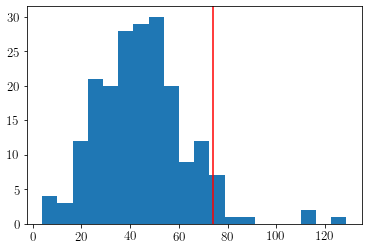

In [90]:
plt.hist(mrois_nv_perm, bins=20)
plt.axvline(x=ths_roi_nv, color='red')

In [92]:
rb_nv_est = np.zeros((num_time, num_time))

mask_cp = rej_nv_est.copy(); iter_blob = 0
while np.any(mask_cp):
    iter_blob += 1
    queue = [tuple(np.transpose(np.where(mask_cp))[0])]
    mask_cp[queue[0]] = False
    while len(queue) > 0:
        cur = queue.pop(0)
        rb_nv_est[cur[0], cur[1]] = iter_blob
        if cur[0] > 0:
            if mask_cp[cur[0]-1, cur[1]]:
                queue.append((cur[0]-1, cur[1]))
                mask_cp[cur[0]-1, cur[1]] = False
        if cur[0] < num_time-1:
            if mask_cp[cur[0]+1, cur[1]]:
                queue.append((cur[0]+1, cur[1]))
                mask_cp[cur[0]+1, cur[1]] = False
        if cur[1] > 0:
            if mask_cp[cur[0], cur[1]-1]:
                queue.append((cur[0], cur[1]-1))
                mask_cp[cur[0], cur[1]-1] = False
        if cur[1] < num_time-1:
            if mask_cp[cur[0], cur[1]+1]:
                queue.append((cur[0], cur[1]+1))
                mask_cp[cur[0], cur[1]+1] = False
nb_nv_est = iter_blob

In [93]:
rois_nv_est = np.zeros(nb_nv_est+1)
for iter_blob in range(1, nb_nv_est+1):
    rois_nv_est[iter_blob] = np.sum(-np.log(pval_est[rb_nv_est == iter_blob]))

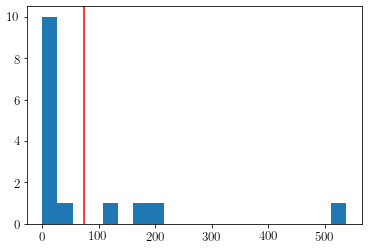

In [94]:
plt.hist(rois_nv_est, bins=20)
plt.axvline(x=ths_roi_nv, color='red')

In [97]:
np.mean(rois_nv <= mrois_nv_perm[:,None], 0)

array([1.   , 0.   , 0.47 , 1.   , 1.   , 0.98 , 0.005, 0.99 , 0.995,
       0.   , 0.97 , 1.   , 0.   , 0.99 , 1.   ])

## plot

Text(0.5, 0, 'series 2 at time $s$')

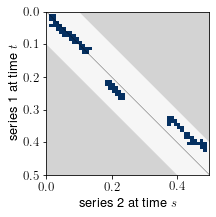

In [96]:
plt.figure(figsize=(3,3))
ldn.imshow(np.isin(rej_blobs, np.where(rois_nv > ths_roi)[0]), time=[rec_time[0], rec_time[1]], identity=True)
plt.fill_between((b_time[offset_cross], rec_time[1]), 
                (rec_time[0], rec_time[0]), 
                (rec_time[0], rec_time[1]-b_time[offset_cross]+rec_time[0]), color='lightgray')
plt.fill_between((rec_time[0], rec_time[1]-b_time[offset_cross]+rec_time[0]), 
                (b_time[offset_cross], rec_time[1]), 
                (rec_time[1], rec_time[1]), color='lightgray')
plt.xlim(rec_time[0], rec_time[1]), plt.ylim(rec_time[1], rec_time[0])
plt.ylabel(r'series 1 at time $t$'); plt.xlabel(r'series 2 at time $s$')
